In [4]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
from lmfit import Model, Parameters
from lmfit.models import ConstantModel
%matplotlib inline

In [62]:
def cross_g2_off_reso(t, offset, A, B, bckg, peak):
    t_set = t - offset
    result = np.zeros(len(t_set))
    
    i = 0
    for tau in t_set:
        if tau < 0:
            result[i] = bckg*(1 + (peak*np.exp(tau/A)))
        else:
            result[i] = bckg*(1 + (peak*np.exp(-tau/B)))
        i = i+1
        
    return result

def fit_cross_g2_off_reso(t_in, coin, coin_err):
    mod = Model(cross_g2_off_reso)
    gmod = mod
    
    #set parameter and make init guess
    p = Parameters()
    p.add('offset', 500)
    p.add('A', 5)
    p.add('B', 50)
    p.add('bckg', 17)
    p.add('peak', 7)
    
    return gmod.fit(coin,t=t_in ,params=p, weights = 1/(coin_err))

def g2_off_reso(t_array, gamma, rabi, detuning, offset, bckg):
    t_set = (t_array - offset)*1e-9
    
    ### necessary matrices
    mat_M = 2*np.pi*np.array([[-.5*gamma,-detuning,0],[detuning,-.5*gamma,rabi],[0,-rabi,-gamma]])
    vec_u = 2*np.pi*np.array([0,0,gamma])
    mat_Minv = np.linalg.inv(mat_M)
    
    ### steady-state solution, which is only true if all Real parts of the eigenvalues 
    vec_Rss = -np.matmul(mat_Minv,vec_u)
    
    # initial Bloch vector
    vec_r0 = np.array([0,0,1])
    vec_r0p = vec_r0 - vec_Rss
    
    w, mat_v = np.linalg.eig(mat_M)
    # check the convergence with the real parts
    if (np.real(w)>=0).any():
        print('Divergent!')
        return 0
    coeff_v = np.linalg.solve(mat_v, vec_r0p)
    coeff_vt = np.transpose([coeff_v])*np.exp (np.transpose([w])*np.abs(t_set))
    zt = np.real(np.matmul(mat_v,coeff_vt)+np.transpose([vec_Rss]))[2,:] #z-coordinate of the Bloch vector at time t
    
    return bckg*(1-zt)/(1-vec_Rss[2])

def fit_g2_off_reso(t_in, coin, coin_err):
    mod = Model(g2_off_reso)
    gmod = mod
    
    #set parameter and make init guess
    p = Parameters()
    p.add('gamma', 6.06e6, vary = 0)
    p.add('rabi', 30e6)
    p.add('detuning', 30e6)
    p.add('offset', 480)
    p.add('bckg', 70)
    
    return gmod.fit(coin,t_array=t_in ,params=p, weights = 1/(coin_err))

In [24]:
data = np.genfromtxt('off_reso_g2.dat')
t_data = data[:,0]
coin = data[:,3]
coin_err = np.sqrt(data[:,3])

fit_result = fit_cross_g2_off_reso(t_data,coin,coin_err)

[[Model]]
    Model(cross_g2_off_reso)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 62
    # data points      = 430
    # variables        = 5
    chi-square         = 465.019030
    reduced chi-square = 1.09416242
    Akaike info crit   = 43.6660420
    Bayesian info crit = 63.9849680
[[Variables]]
    offset:  475.561378 +/- 0.76188109 (0.16%) (init = 500)
    A:       7.81234820 +/- 0.85861615 (10.99%) (init = 5)
    B:       30.4176416 +/- 1.57844371 (5.19%) (init = 50)
    bckg:    13.2555062 +/- 0.20534696 (1.55%) (init = 17)
    peak:    6.73747884 +/- 0.31686677 (4.70%) (init = 7)
[[Correlations]] (unreported correlations are < 0.100)
    C(offset, A)    = 0.710
    C(B, peak)      = -0.522
    C(A, peak)      = -0.341
    C(offset, B)    = -0.279
    C(bckg, peak)   = -0.262
    C(B, bckg)      = -0.253
    C(A, bckg)      = -0.135
    C(offset, peak) = -0.108


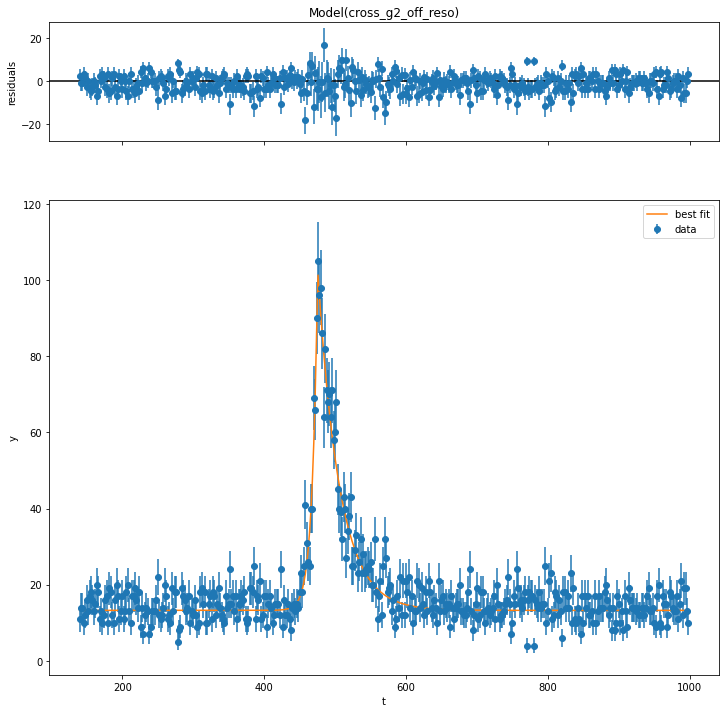

In [25]:
print(fit_result.fit_report())
plt.rcParams["figure.figsize"] = (12,10)
fit_result.plot()
plt.show()

In [63]:
data1 = np.genfromtxt('g2_wo_cavity.dat')
t_data = data1[:,0]
coin = data1[:,3]
coin_err = np.sqrt(data1[:,3])

fit_result = fit_g2_off_reso(t_data,coin,coin_err)

[[Model]]
    Model(g2_off_reso)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 51
    # data points      = 370
    # variables        = 4
    chi-square         = 562.024251
    reduced chi-square = 1.53558538
    Akaike info crit   = 162.675538
    Bayesian info crit = 178.329550
[[Variables]]
    gamma:     6060000 (fixed)
    rabi:      30715536.9 +/- 1083198.09 (3.53%) (init = 3e+07)
    detuning:  28803633.0 +/- 1131263.58 (3.93%) (init = 3e+07)
    offset:    480.940841 +/- 0.12840868 (0.03%) (init = 480)
    bckg:      72.2504294 +/- 0.56242333 (0.78%) (init = 70)
[[Correlations]] (unreported correlations are < 0.100)
    C(rabi, detuning) = -0.974
    C(detuning, bckg) = -0.301
    C(rabi, bckg)     = 0.300


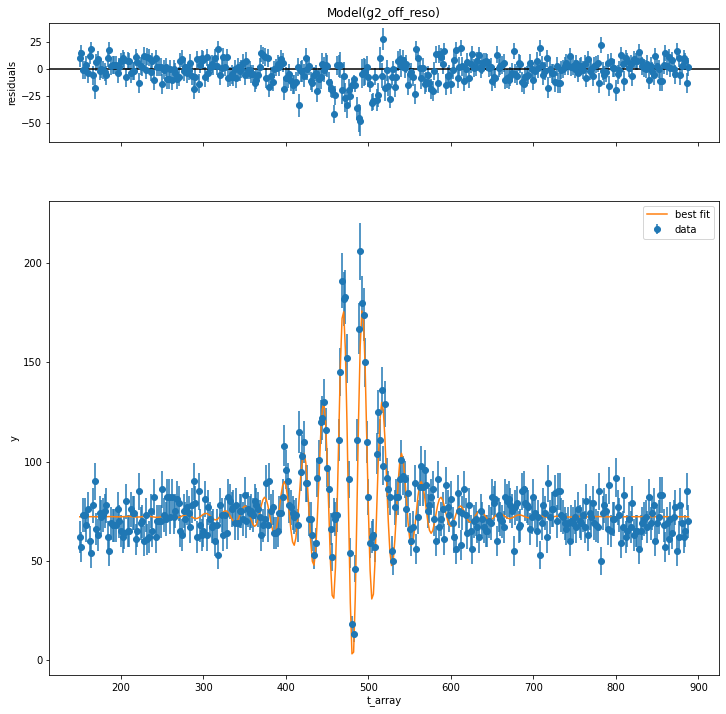

In [64]:
print(fit_result.fit_report())
plt.rcParams["figure.figsize"] = (12,10)
fit_result.plot()
plt.show()

# export simulation result

In [13]:
t_list = np.arange(150,1000,0.5)

result_offset = fit_result.params['offset'].value
result_A = fit_result.params['A'].value
result_B = fit_result.params['B'].value
result_bckg = fit_result.params['bckg'].value
result_peak = fit_result.params['peak'].value

sim_result = cross_g2_off_reso(t_list, result_offset, result_A, result_B, result_bckg, result_peak)

In [14]:
out_text = np.c_[(t_list, sim_result)]
file_name = 'off_reso_g2_sim.dat'
np.savetxt(file_name, out_text, delimiter='\t', fmt='%f', header="time\tg2")

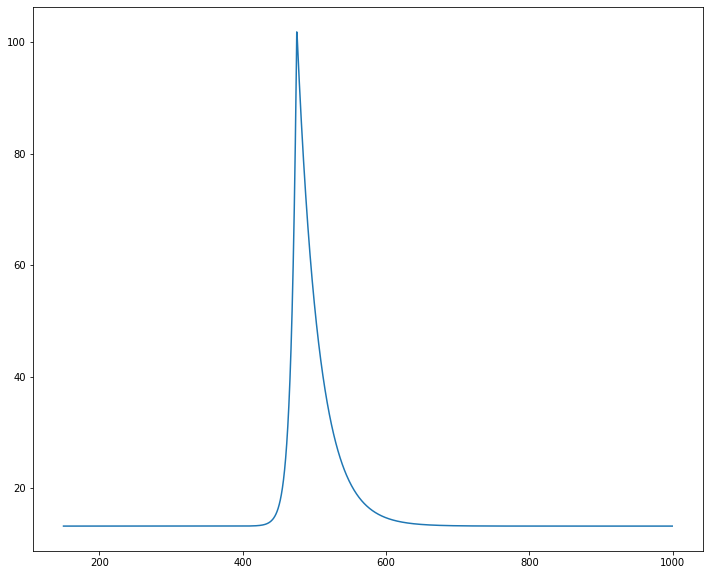

In [15]:
plt.plot(t_list, sim_result)

In [47]:
t_list = np.arange(150,1000,0.5)

result_gamma = fit_result.params['gamma'].value
result_rabi = fit_result.params['rabi'].value
result_detuning = fit_result.params['detuning'].value
result_offset = fit_result.params['offset'].value
result_bckg = fit_result.params['bckg'].value

sim_result = g2_off_reso(t_list, result_gamma, result_rabi, result_detuning, result_offset, result_bckg)

In [48]:
out_text = np.c_[(t_list, sim_result)]
file_name = 'g2_wo_cavity_sim.dat'
np.savetxt(file_name, out_text, delimiter='\t', fmt='%f', header="time\tg2")

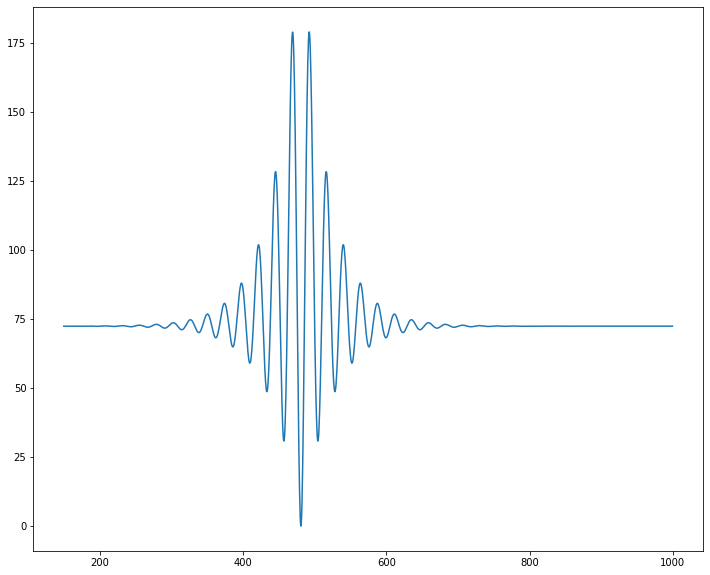

In [49]:
plt.plot(t_list, sim_result)